In [1]:
# Requires xarray_sentinel environment

import os
import sys 
import glob
import dask
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array
from typing import Callable, Union, List, Dict, Any


In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
# TODO perform analysis (averaging) along axis to see whether noise is present since no denoising is performed
# TODO perform era5 wind direction on much higher resolution to improve inversion
# TODO open era5 file if it exists, ELSE download and store
# TODO if high res era5 wdir is usedm, wdir_wrt_sensor should be calculated across slow time

# NOTE We assume a recitilinear geometry with no range migration 
#   NOTE within 60km azimuth the maximum slant-range distance change is approx 1km (+1km and -1km)
# NOTE nrcs weight is calculated per azimuth line

The geometric Doppler is calculated as

\begin{equation}
    f_{d,\mathrm{geom}}\left(Az,Rg\right) = \frac{2V_{\mathrm{LOS}} \cdot \sin\left( \Delta\theta_{Az} \left(Az,Rg\right) \right)}{\lambda}
\end{equation}

with $\Delta \theta$ being the azimuthal angle difference w.r.t the boresight direction down range

\begin{equation}
\tag{2}
    w_{\sigma_0}\left(Az,Rg\right) = \frac{\sigma_{0}\left(Az,Rg\right)}{\left<\sigma_0\left(Az,Rg\right) \right>_{Az}}
\end{equation}

$w_{\sigma_0}$ the local backscatter weight with $\left<\sigma_0\left(Az,Rg\right) \right>_{Az}$ being the along-azimuth average

\begin{equation}
    \beta_{\mathrm{Az}}\left(Az,Rg\right) = \mathrm{sinc}^2\left(\frac{L_A}{\lambda \Delta\theta_{Az}\left(Az,Rg\right)} \right)
\end{equation}

\begin{equation}

    \beta_{\mathrm{Rg}}\left(Az,Rg\right) = \mathrm{sinc}^2\left(\frac{H_A }{\lambda \Delta\theta_{Rg}\left(Az,Rg\right)} \right)
\end{equation}

Assuming a sinc-like beam pattern with $L_A$ and $H_A$ being the antenna length and height respectively

\begin{equation}
    \beta\left(Az,Rg\right) = \beta_{\mathrm{Az}}\left(Az,Rg\right)  \cdot \beta_{\mathrm{Rg}}\left(Az,Rg\right)
\end{equation}

Integrating over the full beam pattern along azimuth yields the leakage dependent LOS velocity, $V_{\mathrm{leakage}}$

\begin{equation}
    V_{\mathrm{leakage}} \left(Rg\right)= \frac{\lambda}{2} 
    \frac
        {\int \frac{f_{d,\mathrm{geom}}}{\sin\left(\theta_{\mathrm{inc}}\right)} \cdot \beta \cdot w_{\sigma_0} \ dAz}
        {\int \beta \cdot w_{\sigma_0} \ dAz}
\end{equation}

Repeating for several pulses yields the slow time, range dependent $V_{\mathrm{leakage}} \left(p, Rg\right)$



In [45]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"

f0 = 5.3E9
z0 = 700E3
c = 3E8
Lambda = c / f0 # # NOTE play with different centre frequency
length_antenna = 3.2
height_antenna = 0.3
incidence_angle_scat = 40
incidence_angle_scat_boresight = 45
vx_sat = 6800 
PRF = 4
stride = vx_sat / PRF
az_mask_cutoff = 60_000 # m
resolution_spatial = 340 # m
scene_size = 25_000
beam_weight_in_scene = 0.9995

az_mask_pixels_cutoff = int(az_mask_cutoff/2//resolution_spatial) 
grg_N = int(scene_size // resolution_spatial)           # number of fast-time samples to avreage to scene size
slow_time_N = int(scene_size // stride)                 # number of slow-time samples to avreage to scene size

In [5]:
# Load files
files = glob.glob(f"{data_dir}*")
# NRCS = grd_to_nrcs(files[2], prod_res=resolution_spatial,  denoise=True)

# NRCS0 = grd_to_nrcs(files[0], prod_res=resolution_spatial,  denoise=True)
# NRCS1 = grd_to_nrcs(files[1], prod_res=resolution_spatial,  denoise=True)
# # # NRCS2 = grd_to_nrcs(files[2], prod_res=resolution_spatial,  denoise=True)
# # # NRCS3 = grd_to_nrcs(files[3], prod_res=resolution_spatial,  denoise=True) # FIXME broken
# # # NRCS4 = grd_to_nrcs(files[4], prod_res=resolution_spatial,  denoise=True)
# NRCS5 = grd_to_nrcs(files[5], prod_res=resolution_spatial,  denoise=True)
# # # NRCS6 = grd_to_nrcs(files[6], prod_res=resolution_spatial,  denoise=True)

# NRCS = xr.merge([NRCS0, NRCS1,NRCS5])
# NRCS0.to_netcdf("0_stitched_scene.nc")
# NRCS.to_netcdf("3_stitched_scenes.nc")

# NRCS = xr.open_dataset("0_stitched_scene.nc")
NRCS = xr.open_dataset("3_stitched_scenes.nc")

NRCS[['NRCS_VV', 'inc']] = xr.where(NRCS.NRCS_VV <0, np.nan, NRCS[['NRCS_VV', 'inc']])
# NRCS = NRCS.dropna(dim='ground_range', how='all').dropna(dim='azimuth_time', how='all')

In [7]:
# Select date and location to querry ERA5
path = '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/'
date = NRCS.azimuth_time.min().values.astype('datetime64[m]').astype(object)
date_rounded = round_to_hour(date)

yy, mm, dd, hh = date_rounded.year, date_rounded.month, date_rounded.day, date_rounded.hour
latmin = latmax = NRCS.latitude.mean().data*1
lonmin = lonmax = NRCS.longitude.mean().data*1

era5_filename = getera5(latmin, latmax, lonmin, lonmax, yy, mm, dd, hh, path=path, retrieve=True)

In [6]:
# Compute wind speed and direction from ERA5
# ------- NOTE ------ make sure the file name corersponds to that belonging to the S1 files
filename = 'era520201110.nc' #era5_filename.split(path)[1]
era5 = xr.open_dataset(filename)
u10, v10 = np.ravel(era5.u10.values*1)[0], np.ravel(era5.v10.values*1)[0]
wdir_era5 = np.rad2deg(np.arctan2(u10, v10))

# Compute orientation of observation
lats, lons = NRCS.latitude.values, NRCS.longitude.values
geodesic = pyproj.Geod(ellps='WGS84')
ground_dir, _, _ = geodesic.inv(lons[0, 0], lats[0, 0], lons[-1,0], lats[-1,0])

# compute directional difference between satelite and era5 wind direction
wdir_wrt_sensor = angular_difference(ground_dir, wdir_era5) # TODO this should be done over short time

In [51]:
# create dataframe with coordinates from scatterometer 
grg_offset = np.tan(np.deg2rad(incidence_angle_scat)) * z0
grg = np.arange(NRCS.latitude.data.shape[1]) * resolution_spatial + grg_offset
az = (np.arange(NRCS.latitude.data.shape[0]) - NRCS.latitude.data.shape[0]//2) * resolution_spatial
x_sat = np.arange(az.min(), az.max(), stride)

data = xr.Dataset(
    data_vars=dict(
        nrcs = (["az", "grg"], NRCS.NRCS_VV.data, {'units': 'm2/m2'}),
        inc = (["az", "grg"], NRCS.inc.data, {'units': 'Degrees'}),
    ),
    coords=dict(
        az = (["az"], az, {'units': 'm'}),
        grg = (["grg"], grg, {'units': 'm'}),
    ),
    attrs=dict(
        wdir_wrt_sensor = wdir_wrt_sensor,
        resolution_spatial = resolution_spatial),
)

# add windfield
windfield = cmod5n_inverse(data["nrcs"].values, data.wdir_wrt_sensor, data["inc"].values)

# for some reason cmod still returns a value even when input is nan, here these are removed
windfield = xr.where(data.nrcs.isnull(), np.nan, windfield)
data["windfield"] = windfield

# add another dimension for later use
x_sat = np.arange(data.az.min(), data.az.max(), stride)
data['x_sat'] = (["slow_time"], x_sat)

In [52]:
# compute beam mask around 
beam_center = abs(data['x_sat'] - data['az']).argmin(dim=['az'])['az'].values 

masks = []
for i in beam_center:
    mask = np.nan * np.zeros_like(data['az'])  # create a mask
    lower_limit = np.where(i-az_mask_pixels_cutoff < 0, 0, i-az_mask_pixels_cutoff)
    mask[lower_limit:i+az_mask_pixels_cutoff+1] = 1
    masks.append(mask)

ds_mask = xr.Dataset(
    data_vars=dict(
        mask_az_st = (["az","slow_time"], np.array(masks).T), 
        mask_grg = (["grg"], np.ones_like(data.grg))),
    coords=dict(
        az=(["az"], data['az'].values),
        grg=(["grg"], data['grg'].values),
        time_slow=(["slow_time"], data['slow_time'].values),),
)

In [53]:
def remove_outside_beampattern(ds, dim_filter: str, dim_new: str, dim_new_res: Union[int, float] = 1):
    """
    Function to remove data along specific coordinates which corresponding to a mask array in the ds

    input
    -----
    ds: xr.Dataset, dataset that contains a 'mask' field and has an attribute 'resolution_spatial'
    dim_filter: str, name of dimension to filter 
    dim_new: str, new name of filtered dimension
    dim_new_res: Union[int, float], resolution along new dimension

    output
    -------
    ds: xr.Dataset, dataset with old dimension replaced
    """

    ds = ds.where(ds.mask, drop = True)
    ds = ds.assign_coords({dim_new: (dim_filter, dim_new_res*np.arange(ds.dims[dim_filter]))})
    ds = ds.swap_dims({dim_filter:dim_new})
    ds = ds.reset_coords(names=dim_filter)

    return ds

data['beam_mask'] = ds_mask.mask_az_st * ds_mask.mask_grg
data['mask'] = ~data.beam_mask.isnull()
data = data.groupby('slow_time').map(remove_outside_beampattern, args = ["az", "az_idx", data.attrs['resolution_spatial']])

In [54]:
def windfield_over_slow_time(ds, dims):
    """

    input
    -----
    ds: xr.Dataset, dataset containing the fields 'windfield', 'inc_scatt_eqv' and the attribute 'wdir_wrt_sensor'
    dims: list, list of strings containing the dimensions for which the nrcs is calculated per the equivalent scatterometer incidence

    output
    ------
    ds: xr.Dataset, dataset containing a new variable 'nrcs_scat_eqv'
    """

    nrcs_scatterometer_equivalent = cmod5n_forward(ds['windfield'].values, ds.attrs['wdir_wrt_sensor'], ds['inc_scatt_eqv'].values)
    ds['nrcs_scat_eqv'] = (dims, nrcs_scatterometer_equivalent, {'units': 'm/s'}) 
    
    return ds

# calculate surface distance between sensor and point on surface as well as equivalent incidence angle for sensor
data['distance_ground'] = calculate_distance(x = data["az"], y = data["grg"], x0 = data["x_sat"]) 
data['inc_scatt_eqv'] = np.rad2deg(np.arctan(data['distance_ground']/z0))
data = data.groupby('slow_time').map(windfield_over_slow_time, dims = ['az_idx', 'grg']).transpose('az_idx', 'grg', 'slow_time')

In [56]:
# calculate beam geometries
data['distance_slant_range'] = np.sqrt(data['distance_ground']**2 + z0**2)
data['az_angle_wrt_boresight'] = np.arcsin((- data["x_sat"] + data["az"] )/data['distance_slant_range']) # incidence from boresight
data['grg_angle_wrt_boresight'] = np.deg2rad(data['inc_scatt_eqv'] - incidence_angle_scat_boresight)
data = data.transpose('az_idx', 'grg', 'slow_time')

# calculate beam patterns 
# NOTE use phased array or standard sinc
beam_rg = sinc_bp(np.sin(data['az_angle_wrt_boresight']), L=length_antenna, f0=f0)**2
beam_az = sinc_bp(np.sin(data['grg_angle_wrt_boresight']), L=height_antenna, f0=f0)**2
# NOTE when using phased array, is tapering only applied on receive?
# beam_rg = np.squeeze(phased_array(np.sin(data['az_angle_wrt_boresight']), L=length_antenna, f0=f0, N=10, w=0.5)**2)
# beam_az = np.squeeze(phased_array(np.sin(data['grg_angle_wrt_boresight']), L=height_antenna, f0=f0, N=10, w=0.5)**2)

data['beam_grg'] = (['az_idx', 'grg', 'slow_time'], beam_rg)
data['beam_az'] = (['az_idx', 'grg', 'slow_time'], beam_az)
data['beam_grg_az'] = data['beam_grg'] * data['beam_az']

In [57]:
# calculation from geometrical doppler and LOS velocity
data['dop_geom'] = (2 * vx_sat * np.sin(data.az_angle_wrt_boresight) / Lambda) # eq. 4.34 from Digital Procesing of Synthetic Aperture Radar Data by Ian G. Cummin
data['beam'] = data['beam_grg_az'] * data['beam_mask'] 
data['nrcs_weight'] = (data['nrcs_scat_eqv'] / data['nrcs_scat_eqv'].mean(dim=['az_idx']))
data['dop_beam_weighted'] = data['dop_geom'] * data['beam']* data['nrcs_weight']
data['V_leakage'] = Lambda * data['dop_beam_weighted'] / (2 * np.sin(np.deg2rad(data['inc_scatt_eqv']))) # using the equivalent scatterometer incidence angle

# compute scatt equivalent nrcs
data['nrcs_scat'] = ((data['nrcs_scat_eqv'] * data['beam']).sum(dim='az_idx') / data['beam'].sum(dim='az_idx'))

# sum over azimuth to receive range-slow_time results
weight_rg = (data['beam'] * data['nrcs_weight']).sum(dim='az_idx', skipna=False)
receive_rg = data[['dop_beam_weighted', 'V_leakage']].sum(dim='az_idx', skipna=False)
data[['doppler_pulse_rg', 'V_leakage_pulse_rg']] = receive_rg / weight_rg

# set data to nan for which too much of the beam weights fall outside the scene (ramping up/down)
data['beam_cutoff'] = data['beam'].sum(dim = ['az_idx', 'grg'])/ data['beam'].sum(dim = ['az_idx', 'grg']).max() < beam_weight_in_scene
data[['doppler_pulse_rg', 'V_leakage_pulse_rg', 'nrcs_scat']][dict(slow_time=data['beam_cutoff'])] = np.nan

# add attributes and coarsen data to resolution of subscenes
data['V_leakage_pulse_rg'] = data['V_leakage_pulse_rg'].assign_attrs(units= 'm/s', description = 'Line of sight velocity ')
subscenes = data[['doppler_pulse_rg', 'V_leakage_pulse_rg']].coarsen(grg=grg_N, slow_time=slow_time_N, boundary='trim').mean(skipna=False) 

In [58]:
# # for saving
# data[['doppler_pulse_rg', 'V_leakage_pulse_rg', 'nrcs_scat']].to_netcdf("scatt4ML.nc")

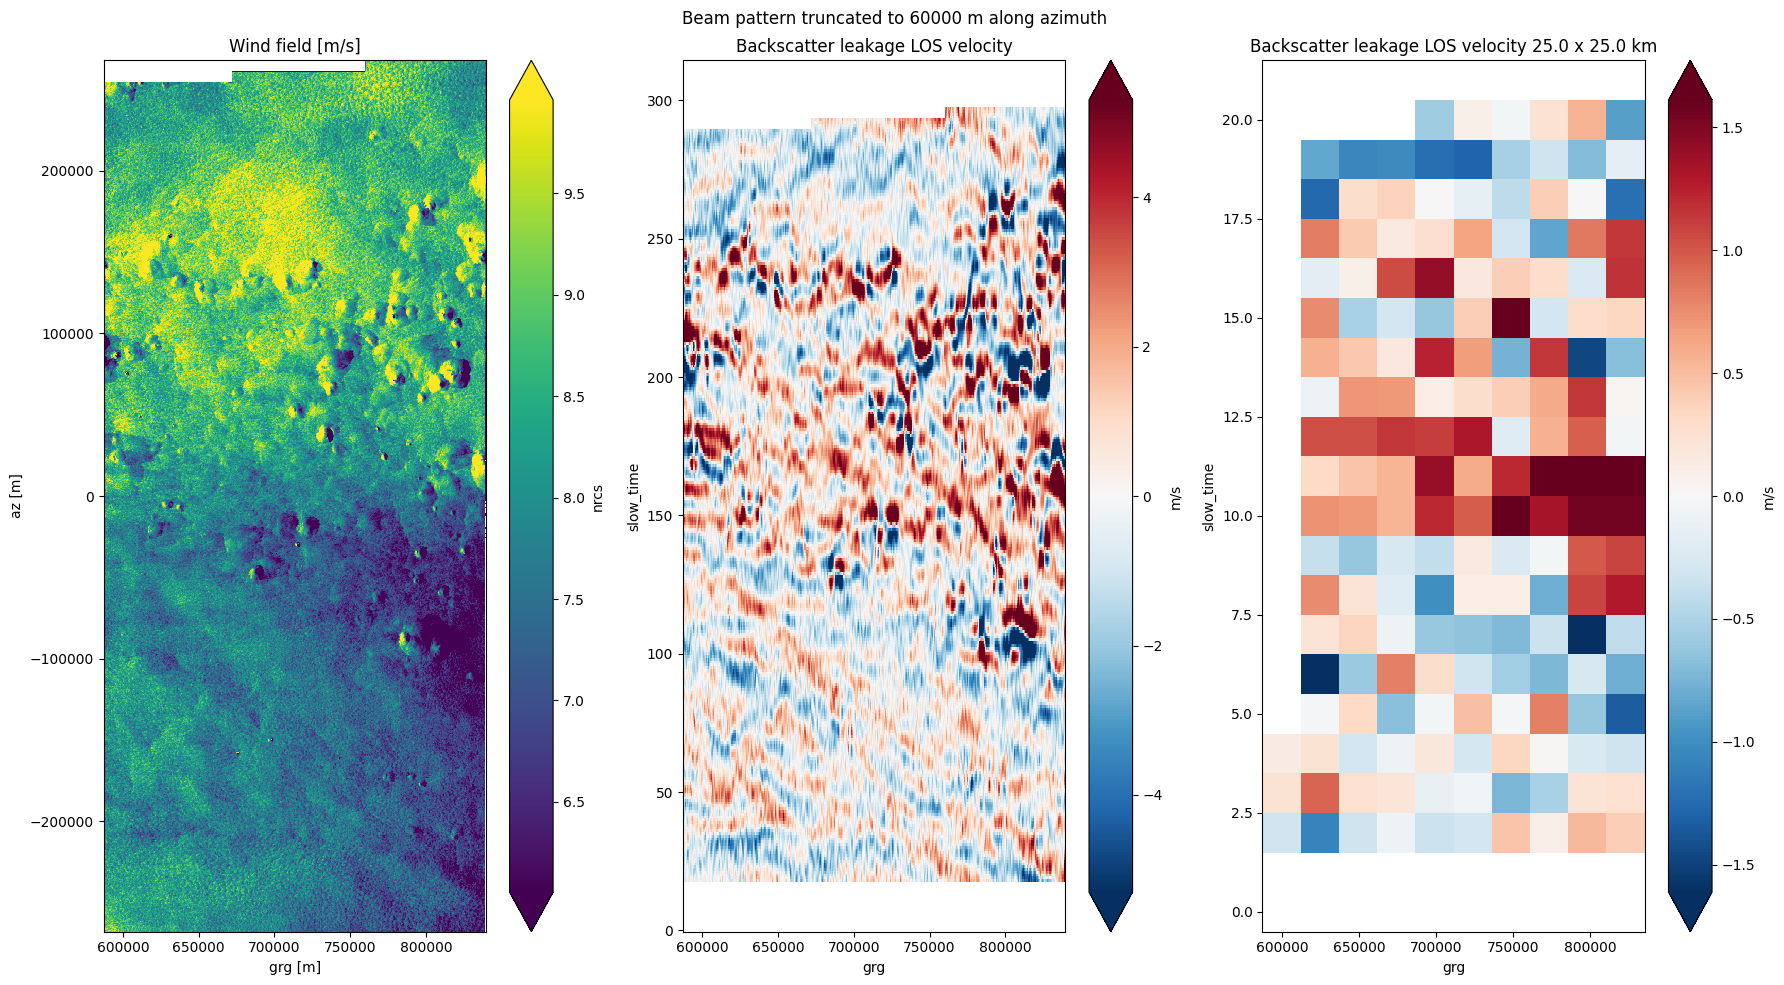

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharex=False)
windfield.plot(robust = True, ax=axes[0])
data['V_leakage_pulse_rg'].T.plot(robust = True, ax=axes[1], cbar_kwargs={'label': data['V_leakage_pulse_rg'].attrs['units']})
subscenes['V_leakage_pulse_rg'].T.plot(robust = True, ax=axes[2], cbar_kwargs={'label': data['V_leakage_pulse_rg'].attrs['units']})
axes[0].set_title('Wind field [m/s]')
_ = axes[1].set_title('Backscatter leakage LOS velocity')
_ = axes[2].set_title(f'Backscatter leakage LOS velocity {scene_size/1000} x {scene_size/1000} km')
fig.suptitle(f'Beam pattern truncated to {az_mask_cutoff} m along azimuth')
fig.tight_layout()